in this file I implemented BERT model and trained it with HugginFace Trainer

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.3 MB/s eta 0:00:00


In [3]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer

In [4]:
#Read file and seperate each line and convert it to a DataFrame
def read_file(path, label):
    df = pd.read_csv(path, delimiter = "\n", names=["text", 'label'])
    df['label'] = label
    return df


In [19]:
#Read data from files
df_attar = read_file('attar_stp_rmv.txt', 'attar')
df_fer = read_file('ferdousi_stp_rmv.txt', 'ferdousi')
df_hafez = read_file('hafez_stp_rmv.txt', 'hafez')
df_jami = read_file('jami_stp_rmv.txt', 'jami')
df_khayam = read_file('khayyam_stp_rmv.txt', 'khayyam')
df_manoch = read_file('manoochehri_stp_rmv.txt', 'manoochehri')
df_moulavi = read_file('moulavi_stp_rmv.txt', 'moulavi')
df_parvin = read_file('parvin_stp_rmv.txt', 'parvin')
df_saeb = read_file('saeb_stp_rmv.txt', 'saeb')
df_sanaee = read_file('sanaee_stp_rmv.txt', 'sanaee')


df_small = pd.concat([df_attar, df_fer,df_hafez,df_jami,df_khayam,df_manoch,df_moulavi,df_parvin,df_saeb,df_sanaee], ignore_index=True)
df = df_small.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,رحم جو دل سندان,moulavi
1,همیدون فزونم بمردان گنج,ferdousi
2,قصر خجسته بنا,manoochehri
3,شکستی نشایدش بست,ferdousi
4,بو نقد ورطه بیم,jami


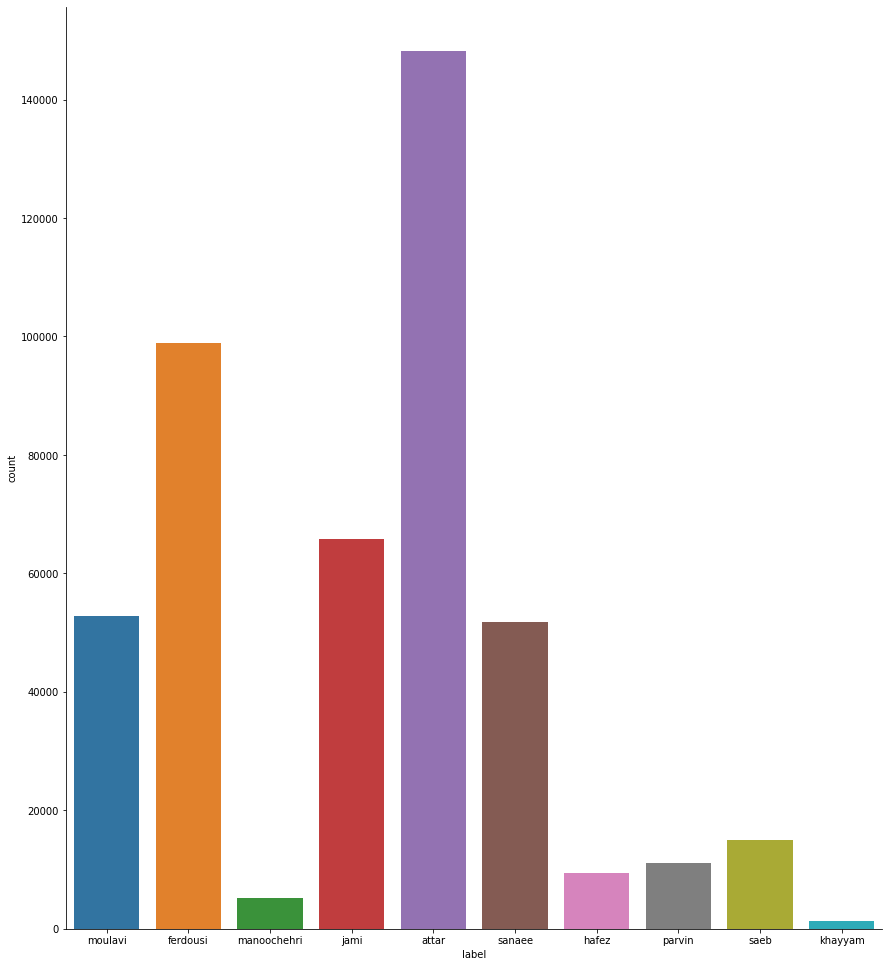

In [20]:
g=sns.catplot(data=df, x='label', kind='count')
g.fig.set_size_inches(15,15)
plt.show()

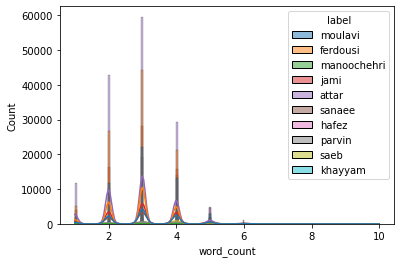

In [22]:

df['word_count'] = df['text'].str.count(' ') + 1

g=sns.histplot(data=df, x='word_count', hue='label', kde=True)
plt.show()

In [23]:
from transformers import BertForSequenceClassification, BertTokenizer

model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=10)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [24]:
#Encode the label
df['label'] = pd.factorize(df['label'])[0]

#Split dataset
X = list(df['text'])
y = list(df['label'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

#Tokenize dataset
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [25]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, label=None):
        self.encodings = encodings
        self.label = label

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.label:
            item["label"] = torch.tensor(self.label[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [26]:
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=preds)
    f1 = f1_score(y_true=labels, y_pred=preds,average='micro')

    return {"accuracy":accuracy, "f1": f1}

### Model Bert layer is freezed and just Classify layer is trained

In [ ]:
for param in model.bert.parameters():
    param.requires_grad = False


### model is trained of classification layer for 5 epochs and reached 44% accuracy

In [62]:


from transformers import AdamW,AdamWeightDecay

args = TrainingArguments(
    output_dir="output/bert",
    run_name="BERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=5,
    logging_steps = 10,
    seed=0,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 400078
  Num Epochs = 5
  Instantaneous batch size per device = 100
  Total train batch size (w. parallel, distributed & accumulation) = 100
  Gradient Accumulation steps = 1
  Total optimization steps = 20005
  Number of trainable parameters = 7690


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.682500,1.606771,0.438612,0.438612
2,1.615800,1.583659,0.443801,0.443801
3,1.639200,1.575057,0.446571,0.446571
4,1.553100,1.569760,0.447650,0.447650
5,1.636400,1.568309,0.448200,0.448200


Saving model checkpoint to output/bert/checkpoint-500
Configuration saved in output/bert/checkpoint-500/config.json
Model weights saved in output/bert/checkpoint-500/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-1000
Configuration saved in output/bert/checkpoint-1000/config.json
Model weights saved in output/bert/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-1500
Configuration saved in output/bert/checkpoint-1500/config.json
Model weights saved in output/bert/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-2000
Configuration saved in output/bert/checkpoint-2000/config.json
Model weights saved in output/bert/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-2500
Configuration saved in output/bert/checkpoint-2500/config.json
Model weights saved in output/bert/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-3000
Configuration

TrainOutput(global_step=20005, training_loss=1.6272413235192178, metrics={'train_runtime': 2217.3895, 'train_samples_per_second': 902.137, 'train_steps_per_second': 9.022, 'total_flos': 1.644882904031808e+16, 'train_loss': 1.6272413235192178, 'epoch': 5.0})

### PART B _ fine tune 
### in this part Colab suddenly crashed(Lack of DISC) for 2 times after 3 epochs
### so I tried to implement this part with tensorflow keras which results are available in another ipynb file

In [ ]:
# for param in model.bert.parameters():
#     param.requires_grad = False

from transformers import BertForSequenceClassification, BertTokenizer

#Load the model
model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=10)
from transformers import AdamW,AdamWeightDecay

args = TrainingArguments(
    output_dir="output/bert",
    run_name="BERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=5,
    logging_steps = 10,
    seed=0,
)
optimizer = AdamW(model.parameters(), lr=3e-5),
# optimizer=AdamWeightDecay()
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--HooshvareLab--bert-fa-base-uncased/snapshots/a04aa40c97bcdde570ae11986a534542c2995a62/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--HooshvareLab--bert-fa-base-uncased/snapshots/a04aa40c97bcdde570ae11986a534542c2995a62/config.json
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-fa-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_t

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.111800,1.086278,0.624052,0.624052
2,0.958200,1.020687,0.649209,0.649209
3,0.825100,1.022186,0.662474,0.662474


Saving model checkpoint to output/bert/checkpoint-500
Configuration saved in output/bert/checkpoint-500/config.json
Model weights saved in output/bert/checkpoint-500/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-1000
Configuration saved in output/bert/checkpoint-1000/config.json
Model weights saved in output/bert/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-1500
Configuration saved in output/bert/checkpoint-1500/config.json
Model weights saved in output/bert/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-2000
Configuration saved in output/bert/checkpoint-2000/config.json
Model weights saved in output/bert/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-2500
Configuration saved in output/bert/checkpoint-2500/config.json
Model weights saved in output/bert/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to output/bert/checkpoint-3000
Configuration

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AdamW,AdamWeightDecay

#Load the model
model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=10)



args = TrainingArguments(
    output_dir="output/bert",
    run_name="BERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=2,
    logging_steps = 10,
    seed=0,
)
# optimizer = AdamW(model.parameters(), lr=3e-5),
optimizer=AdamWeightDecay()
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
